Hypothesis: the model optimizations (force-consider; graph-normalization; and both) do not affect the payoff of the optimal policy

Fact: The policy itself is affected as state and action spaces are not the same after applying the optimizations.

Plan: Take the models with fixed exploration depth, solve MDPs compare results.

In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("4-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,depth,size,time_spent,rss,mdp
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,3,23,0.159029,0.133991,6205f68c
1,baseline,generic_1,False,False,True,True,False,bitcoin,3,740,0.369479,0.161179,36742e55
2,baseline,generic_1,False,False,True,True,False,ethereum_3,3,1391,1.192166,0.169106,7e3322ee
3,baseline,generic_1,False,False,True,True,False,byzantium_3,3,1391,1.247024,0.175041,45fc8070
4,baseline,generic_1,False,False,True,True,False,ghostdag_3,3,1268,1.447537,0.177250,40cf35f6
5,baseline,generic_1,False,False,True,True,False,parallel_3,3,2555,1.685983,0.183735,40b6e69a
6,w/ force consider,generic_1,True,False,True,True,False,bitcoin,3,397,0.712030,0.180618,211ba346
7,w/ force consider,generic_1,True,False,True,True,False,ethereum_3,3,1587,1.534235,0.184250,22274d31
8,w/ force consider,generic_1,True,False,True,True,False,byzantium_3,3,1587,1.658108,0.186840,5badc29b
9,w/ force consider,generic_1,True,False,True,True,False,ghostdag_3,3,607,1.099605,0.188793,5384ef9c


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 100
stop_delta = (
    0.001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                _episode_reward_per_progress=episode_reward
                / episode_progress,  # progress is already accounted for via ptmdp/horizon
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df.to_pickle("6-value-iterations.pkl.gz")
df

100%|███████████████████████████████████████████| 84/84 [04:29<00:00,  3.21s/it]


,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,depth,size,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,_episode_reward_per_progress
0,reference,fc16sapirshtein,True,True,True,True,True,bitcoin,3,23,...,0.33,1,0.000992,0.001,699,0,0.075278,36.700553,99.950094,0.367189
1,baseline,generic_1,False,False,True,True,False,bitcoin,3,740,...,0.33,1,0.001000,0.001,1346,0,2.069339,33.424771,99.290512,0.336636
2,baseline,generic_1,False,False,True,True,False,ethereum_3,3,1391,...,0.33,1,0.001000,0.001,1540,0,4.536512,43.098534,99.351565,0.433798
3,baseline,generic_1,False,False,True,True,False,byzantium_3,3,1391,...,0.33,1,0.000997,0.001,1224,0,3.689738,33.657068,99.499860,0.338262
4,baseline,generic_1,False,False,True,True,False,ghostdag_3,3,1268,...,0.33,1,0.000998,0.001,1173,0,3.496068,34.505368,99.583831,0.346496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,w/ both,generic_1,True,True,True,True,False,bitcoin,3,192,...,0.66,1,0.000997,0.001,1632,0,0.818222,52.172061,99.466196,0.524521
80,w/ both,generic_1,True,True,True,True,False,ethereum_3,3,487,...,0.66,1,0.000998,0.001,1633,0,2.030534,57.291929,99.497741,0.575811
81,w/ both,generic_1,True,True,True,True,False,byzantium_3,3,487,...,0.66,1,0.001000,0.001,1344,0,1.650971,48.034869,99.682268,0.481880
82,w/ both,generic_1,True,True,True,True,False,ghostdag_3,3,265,...,0.66,1,0.000997,0.001,1227,0,0.892706,39.591785,99.692305,0.397140


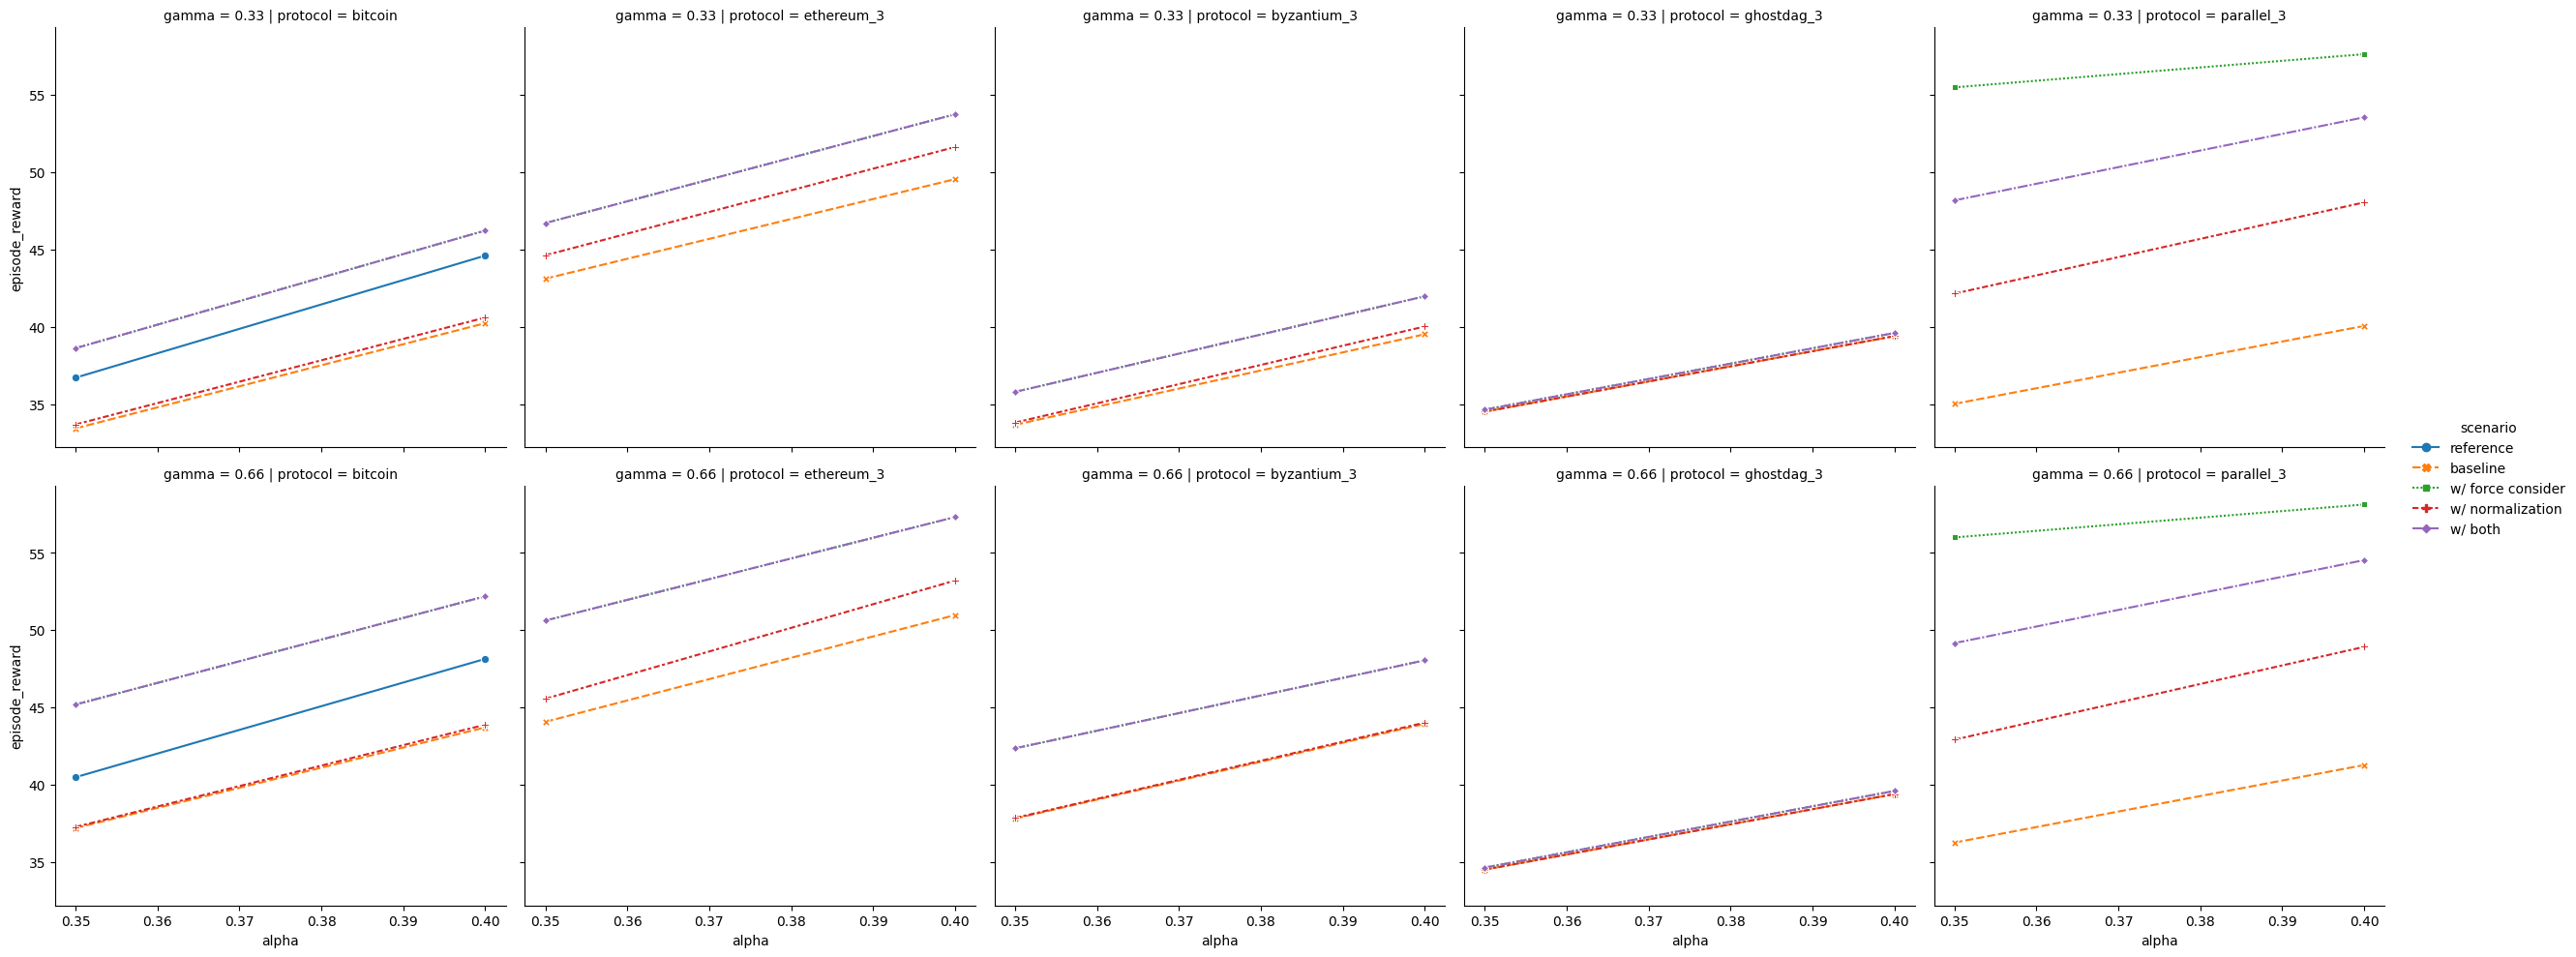

In [13]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

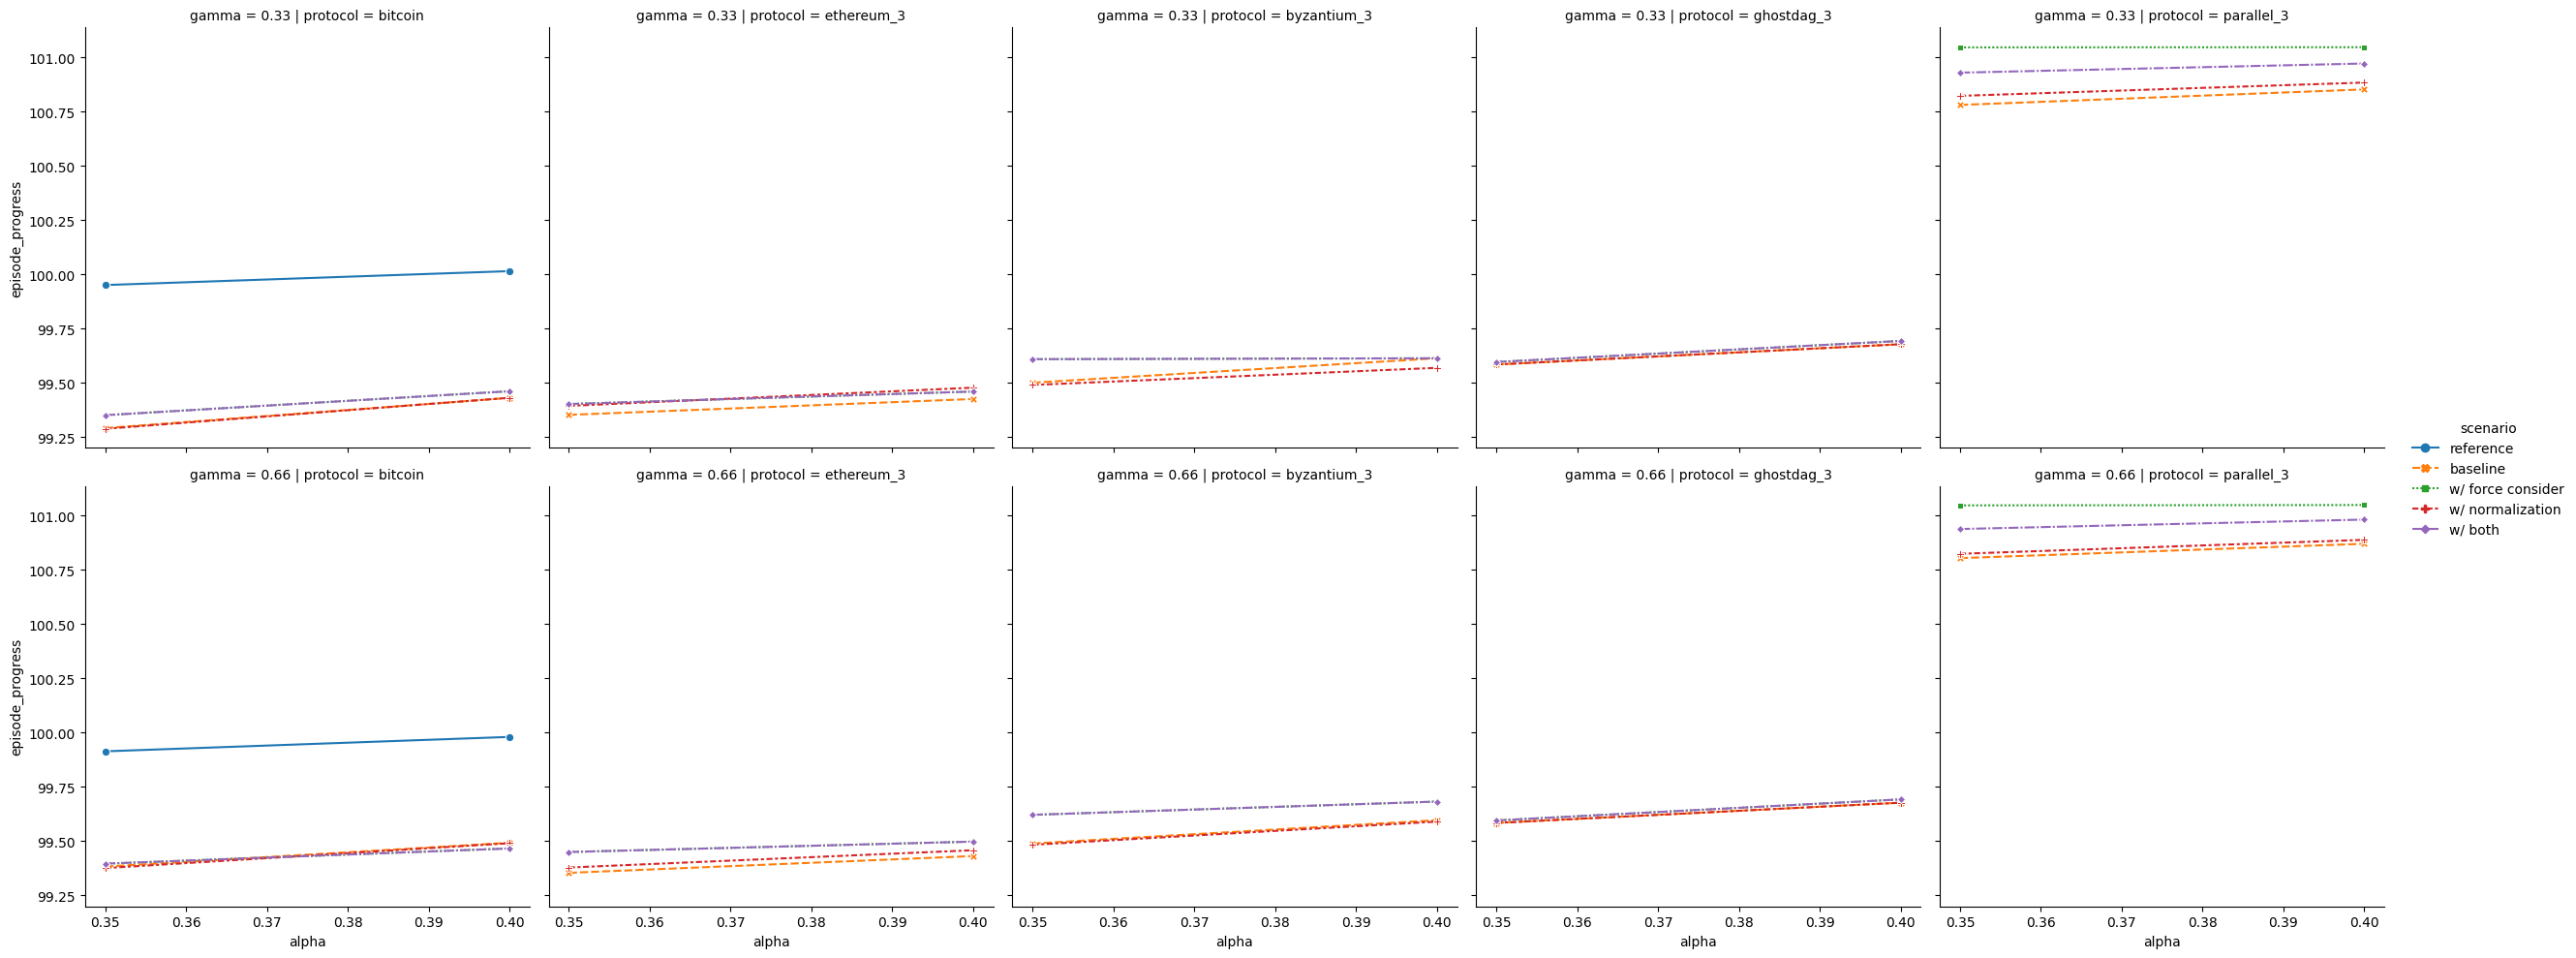

In [7]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

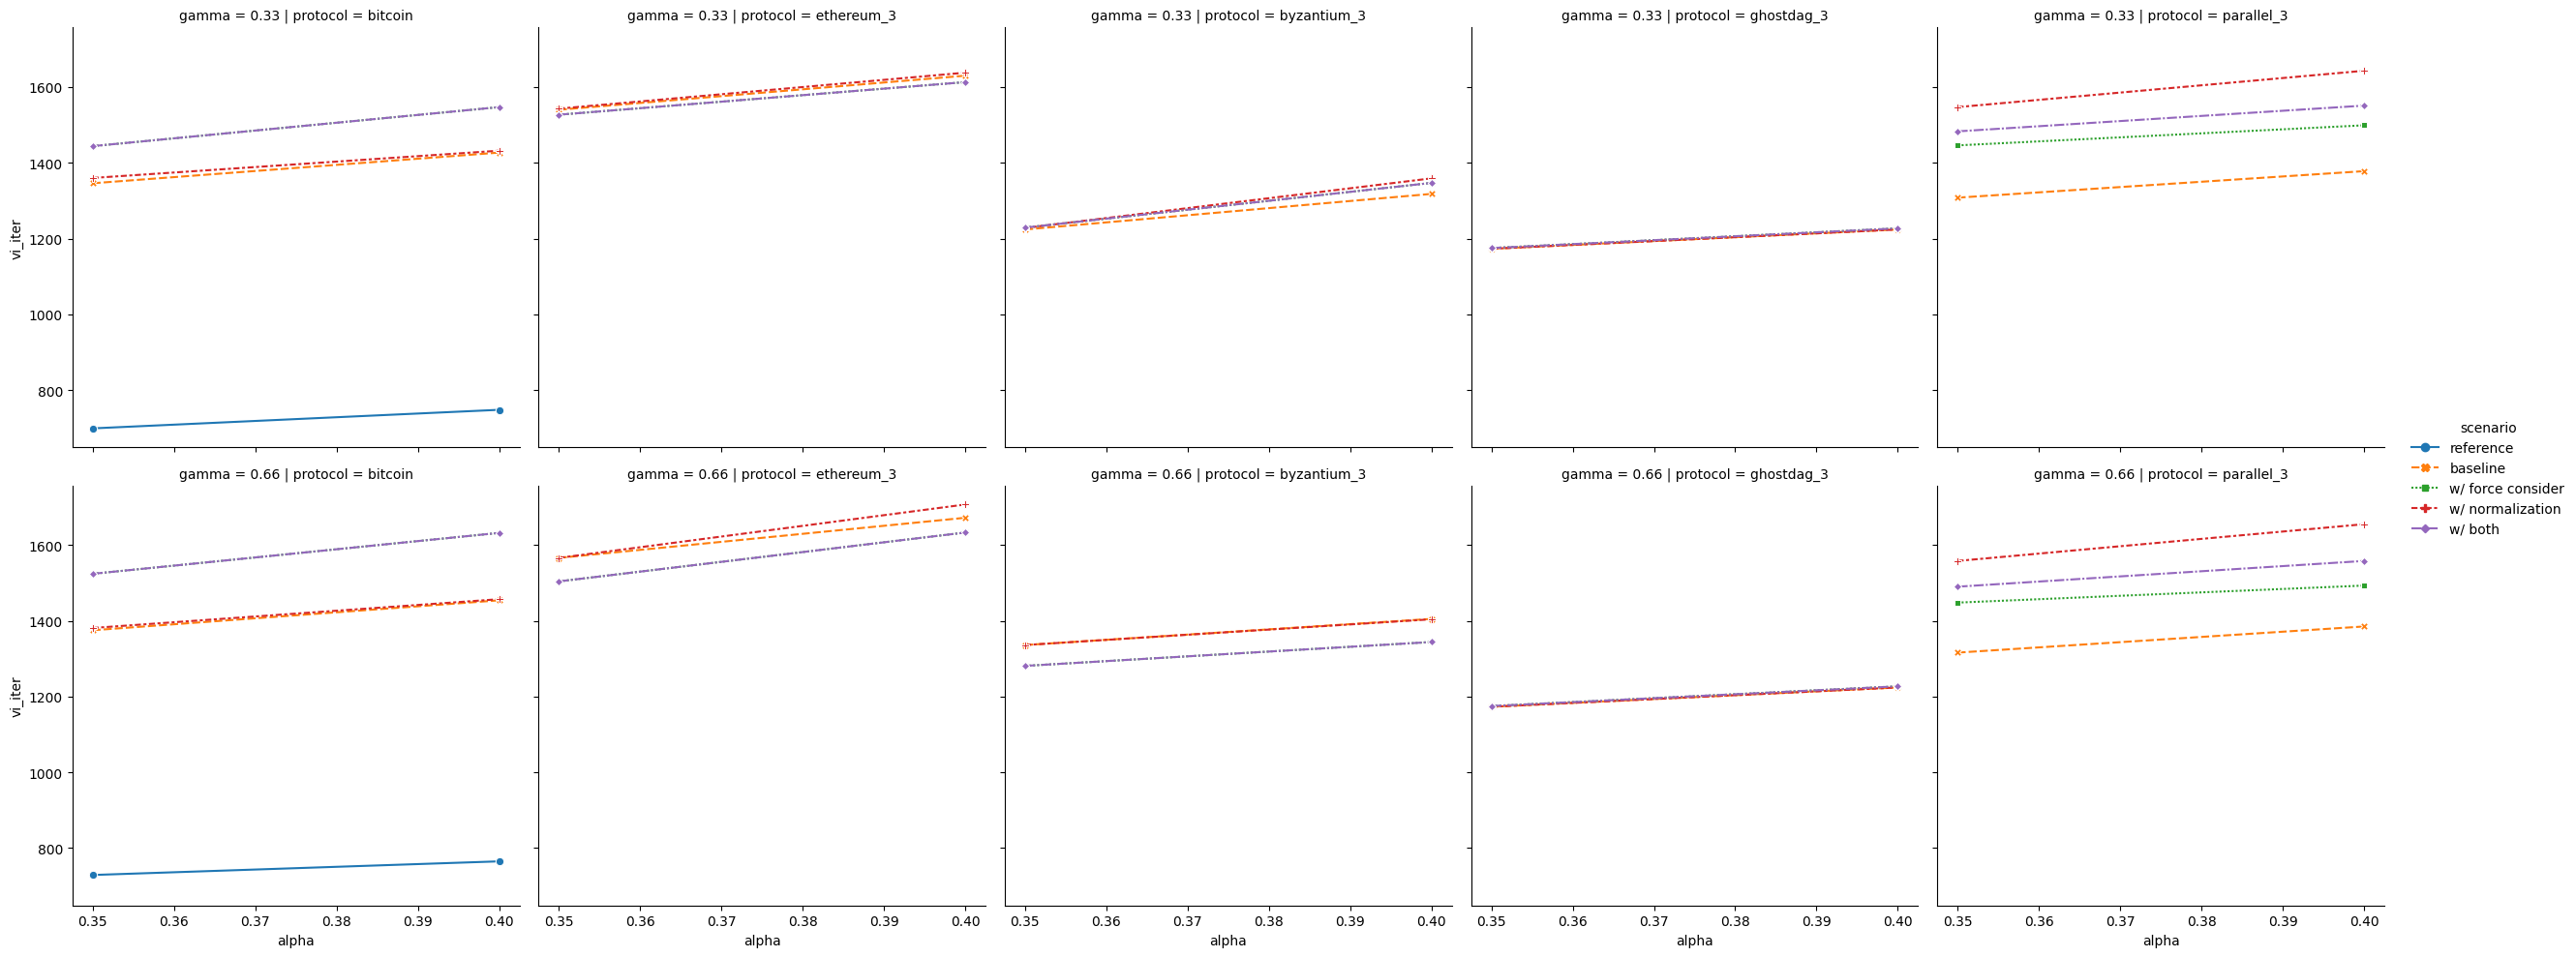

In [8]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    markers=True,
    row="gamma",
)

# Stop condition for value iteration

An *approved* stop condition for $\varepsilon$-optimal policy with `discount` factor:

```python
stop_delta = eps * ( 1 - discount ) / discount
```

Now, what is our discount factor? We're discounting for progress (PT MDP) and depending on the horizon.
The termination probability for horizon `H` and progress `Dt` is:

```python
term_prob = 1.0 - ((1.0 - (1.0 / H)) ** Dt)
```

I think our termination probability is somewhat similar to `(1 - discount)` in the infinite horizon value iteration. **(can it?)**

Let's tabulate this to get a feeling

In [9]:
H = 10
Dt = range(0, 4)
term_prob = [1.0 - ((1.0 - (1.0 / H)) ** p) for p in Dt]
pseudo_discount = [1 - tp for tp in term_prob]
[(1 - discount) / discount for discount in pseudo_discount]  # stop_delta / eps

[0.0, 0.11111111111111108, 0.23456790123456783, 0.37174211248285305]

So the smallest progress drives the stop delta. That's cool, because I think the smallest non-zero progress should be one in all protocols. **(checked below)**.

What is our $\varepsilon$?

The horizon scales the expected reward linearly. Max reward equals horizon. If we increase the horizon we can also increase the epsilon to stay at the same precision.

In [10]:
digits_precision = 3
H = [10, 100, 1000]
eps = [h / (10**digits_precision) for h in H]
eps

[0.01, 0.1, 1.0]

In [11]:
def stop_delta(horizon, digits_precision, min_progress=1):
    tp = 1.0 - ((1.0 - (1.0 / horizon)) ** min_progress)
    pd = 1 - tp
    eps = horizon / (10**digits_precision)
    return eps * (1 - pd) / pd


[stop_delta(h, 3) for h in [10, 100, 1000]]

[0.001111111111111111, 0.001010101010101011, 0.0010010010010010019]

So, no matter how we scale the horizon, the stop delta can be around 0.001 if we want 3 digit precision.

Now, it seems the observed errors above are _much_ higher.

# Minimum progress

The above assumes `min_progess = 1`. Let's see whether this is true.

In [12]:
rows = []
for i, row in mdps.iterrows():
    with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)

    min_prg = 10000
    min_prg_nonzero = 10000
    max_prg = 0
    for state_actions in emdp.tab:
        for action_transitions in state_actions:
            for transition in action_transitions:
                min_prg = min(min_prg, transition.progress)
                max_prg = max(max_prg, transition.progress)
                if transition.progress > 0:
                    min_prg_nonzero = min(min_prg_nonzero, transition.progress)

    rows.append(
        row.to_dict()
        | dict(max_prg=max_prg, min_prg=min_prg, min_prg_nonzero=min_prg_nonzero)
    )

prg_check = pandas.DataFrame(rows)
assert prg_check.min_prg.min() >= 0
assert prg_check.min_prg_nonzero.min() >= 1